# Yahoo Finance API
The goal of this notebook is to take a subsample of our 'all_common_stock_purchases.csv' file and take key features like 'transaction_date' and 'ticker' to scrape yahoo finance and find the price data for given time periods after the transaction. We will start by mounting our drive.

In [1]:
#Start by importing drive from google.colab
from google.colab import drive
#Mount the drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

#Students Google Drive Path
toms_path = '/content/drive/MyDrive/Colab Notebooks/593 - Milestone I/593 - Insider Trading Milestone I Project'
kirts_path = None
ramis_path = None

#Navigate to the right working directory and confirm our current working drive
os.chdir(toms_path)
#os.chdir(kirts_path)
#os.chdir(ramis_path)
print(os.getcwd())

/content/drive/MyDrive/Colab Notebooks/593 - Milestone I/593 - Insider Trading Milestone I Project


I have an expectation that this algorithm is going to be pretty slow as we will have to iterate the file row by row, pull out the date and the ticker, request the data, and then pull out the data from a seperate dataframe back into our working dataframe. Due to this, I am going to start with a very small subset of the 'all_common_stock_purchases.csv' file as a proof of concept before we expand it out to the full data set.

So let's start by pulling the file, removing any data instances that have 'None' in the ticker field, and then taking a random sample of just one transactions to see if we can do this.

In [3]:
import numpy as np
import pandas as pd

#Start by taking a quick look at the files in our directory so we can pull the right one
#print(os.listdir())

#Read in the .csv file
cs_df = pd.read_csv('all_common_stock_purchases (6).csv')
print(f"Let's take a look at the size of our dataframe: {cs_df.shape}")
#print(cs_df.head())

#Let's start by removing any data where tickers == None
cs_df = cs_df[cs_df['Ticker'] != 'NONE']
print(f"After removing transction with no tickers we have {cs_df.shape}")

#Let's take a look at the number of unique tickers in this file
tickers = list(cs_df['Ticker'].unique())
print(f"We have {len(tickers)} unique tickers")

#Let's subsample this to see if we can get it working
set_seed = 5
temp_df = cs_df.sample(1, random_state = set_seed)
print(temp_df.shape)

#Let's remove the big dataframe to open up memory
del cs_df

#Confirm we have removed the dataframe from the environment
'cs_df' in globals()

Let's take a look at the size of our dataframe: (5655, 14)
After removing transction with no tickers we have (5567, 14)
We have 925 unique tickers
(1, 14)


False

Now that we have a small dataframe to work with, lets bring in the yahoo finance API and start quering it for price data. We are going to look at end of day close prices for all of the symbols in question. We will look at the ticker at different time points that we can change for our variables. I want to look for both the ticker and the S&P 500 as a comparison.

Before we get started, let's put in a code block of dynamic dates that we can change depending on what we want to look at.

In [ ]:
#Dynamic Date Ranges (days)
pre_trend1 = 28 #One month prior to transaction
pre_trend2 = 21
pre_trend3 = 14
pre_trend4 = 7

post_trend1 = 7 #One week post transaction
post_trend2 = post_trend1 * 4 #One Month
post_trend3 = post_trend1 * 8 #Two Months
post_trend4 = post_trend1 * 12 #Three Months
post_trend5 = post_trend1 * 16 #Four Months
post_trend6 = post_trend1 * 20 #Five Months
post_trend7 = post_trend1 * 24 #Six Months

I kept running into rate limiting errors and after a bunch of research, it looks like yfinance is typically outdated in colab so I am going to run an explicit upgrade in the environment before importing the module.

In [53]:
#Let's explicity update yfiance just incase
!pip install yfinance --upgrade --no-cache-dir

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.9/117.9 kB 7.3 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.59
    Uninstalling yfinance-0.2.59:
      Successfully uninstalled yfinance-0.2.59


That took care of it and I am now able to actually fetch the data.

In [ ]:
#let's bring in the yahoo finance API and datetime
import yfinance as yf
import time
from datetime import timedelta, date, datetime


#We are going to iterate through our dataframe and pull out information
for index, row in temp_df.iterrows():
    #Grab the symbol we will work with
    symbol = row['Ticker']
    #Find out the date of the transaction
    trans_date = pd.to_datetime(row['Transaction Date']).date()
    #Let's look a month before the transaction to six months after the transaction
    start_query = trans_date - timedelta(days = pre_trend1)
    end_query = trans_date + timedelta(days = post_trend7)
    #It's possible the transaction was less than six months ago, if so we can pull up to today
    today = date.today()
    if today < end_query:
        end_query = today

    #Now, lets pull the actual historical price data. We keep running into rate limiting so let's put a rate limit step
    while True:
        try:
            df_close = yf.download(symbol, start = start_query, end = end_query, actions = False, progress = False,auto_adjust = False, threads = False)
            time.sleep(1)
            break
        except:
            print(f"Rate Limitied downloading {symbol}, sleeping 60s...")
            time.sleep(60)
    if df_close.empty:
        print(f"No data for {symbol}")
        continue

    #Let's add the index to our dataframe so that we can easily pull it
    df_close['index'] = index


We now have obtained a temporary dataframe with all of the information that we want. We can filter this dataframe down to only the date, close price and volume. Let's take the adjusted close (accounting for dividends).

In [ ]:
df_close.reset_index(inplace=True)
print(df_close.shape)
df_close = df_close[['Date','Adj Close', 'Volume','index']]
df_close.set_index('Date',inplace=True)
print(df_close.shape)
df_close.head()

(128, 4)
(128, 3)


Price,Adj Close,Volume,index
Ticker,ADMQ,ADMQ,
Date,,,
2024-11-04,0.04900,84372,854
2024-11-05,0.04810,15000,854
2024-11-06,0.04800,85000,854
2024-11-07,0.04800,0,854
2024-11-08,0.04645,16000,854


Let's take a quick look at the trend of the stock over the course of 7 monts (1 month before the insider transaction and six months after). We will also annotate the date of the transaction.

/usr/local/lib/python3.11/dist-packages/matplotlib/text.py:1477: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))


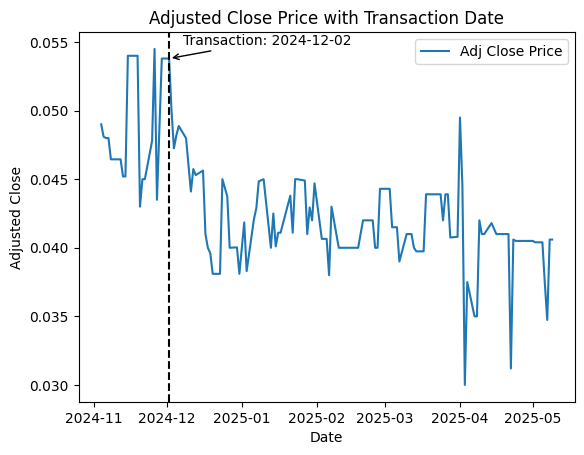

In [ ]:
import matplotlib.pyplot as plt

# Get the nearest available price on or before the transaction date
price_on_trans = df_close['Adj Close'].asof(pd.to_datetime(trans_date))

fig, ax = plt.subplots()
ax.plot(df_close.index, df_close['Adj Close'], label='Adj Close Price')

# Draw a vertical line at the transaction date
ax.axvline(pd.to_datetime(trans_date), linestyle='--', color = 'black')

# Annotate the transaction date on the plot
ax.annotate(
    f'Transaction: {trans_date}',
    xy=(pd.to_datetime(trans_date), price_on_trans),
    xytext=(10, 10),
    textcoords='offset points',
    arrowprops=dict(arrowstyle='->')
)

ax.set_xlabel('Date')
ax.set_ylabel('Adjusted Close')
ax.set_title('Adjusted Close Price with Transaction Date')
ax.legend()

plt.show()


Now, the goal will be to pull out the price and volume at given times before and after the transaction and then add them to our orignal datafame in the right location. We can use this by the index taken from our original dataframe. So we will need to pull out all of the prices based on our 'dynamic variables' specified above.

In [ ]:
#Let's start by pulling the volume one month prior to the trans date
pre_trans_date = pd.to_datetime(trans_date - timedelta(days = pre_trend1))
#Because we are only looking at trading days, we need to take the date closet to our time point
pre_trans_price = float(np.round(df_close['Adj Close'].asof(pre_trans_date).iloc[0],4))
pre_trans_volume = int(df_close['Volume'].asof(pre_trans_date).iloc[0])
index = df_close['index'].iloc[-1]
print(pre_trans_price, pre_trans_volume)

#Now that we have the price and volume we can add it back to our original dataframe based on the index
temp_df.loc[index,'month_pre_close'] = pre_trans_price
temp_df.loc[index,'month_pre_volume'] = pre_trans_volume
temp_df

0.049 84372


,Insider Name,Insider Title,Insider Role,Issuer,Ticker,Period of Report,Transaction Date,Security,Transaction Code,Shares,Price per Share,Shares After,Ownership Type,ACCESSION_NUMBER,month_pre_close,month_pre_volume
854,ARCHER ALEX,CFO,"Director,Officer","ADM ENDEAVORS, INC.",ADMQ,02-DEC-2024,02-DEC-2024,Common Stock,P,30000.0,0.05,220600.0,D,0001493152-24-048936,0.049,84372.0


Alright, so we have been able to take a single entry from our 'all_common_stock_purchase.csv' file and use the data to query yahoo finance and put the date back into the csv file. Now, we would just have to save the new dataframe to a csv or database file. We can work on expanding this out to adding multiple close prices for dates, as well as the S&P 500 for comparison. We can also work on building it out to iterate over every row in the datafile to pull in the information.

# Updated (all historical price data at once)
After Kirt has pulled in all of the insider transactions from 2006 until Q4 2024, we can see that we have $\approx$ 464,000 rows worth of data. This will be a tremendous amount of data that we have to iterate over and a lot of API calls to yfinance. We most certainly will run into rate limiting. Even if we use a timedelay in order to avoid this, you can imagine how long it will take to propogate all of this. A way we can reduce the time is by finding all unique ticker symbols, pulling all price data for that ticker. Then iterating over all transactions for that ticker to pull out the relevant historical price for that transaction. So I am going to attempt to do that here on the smaller dataframe as a proof of concept.

Let's start by reading in the full csv file again. We will pick out a random symbol, and query yahoo finance to fill in the dataframe. It will be important to keep the original indexing so we can put the information back into the appropriate spots.

In [4]:
import numpy as np
import pandas as pd
import random

#Read in the .csv file
cs_df = pd.read_csv('all_common_stock_purchases (6).csv')
print(f"Let's take a look at the size of our dataframe: {cs_df.shape}")
#print(cs_df.head())

#Let's start by removing any data where tickers == None
cs_df = cs_df[cs_df['Ticker'] != 'NONE']
print(f"After removing transction with no tickers we have {cs_df.shape}")

#Let's take a look at the number of unique tickers in this file
tickers = list(cs_df['Ticker'].unique())
print(f"We have {len(tickers)} unique tickers")

random.seed(593)

#Let's pull out a random ticker
ticker = cs_df['Ticker'].sample(1).iloc[0]
print(ticker)

Let's take a look at the size of our dataframe: (5655, 14)
After removing transction with no tickers we have (5567, 14)
We have 925 unique tickers
TTGT


Now, that we have pulled out a random ticker, let's create a filtered dataframe of all insider transactions where that ticker was present.


In [10]:
print(ticker)
#Filtered dataframe
ticker_df = cs_df[cs_df['Ticker'] == ticker].copy()
print(ticker_df.shape)
ticker_df.head()

TTGT
(20, 14)


,Insider Name,Insider Title,Insider Role,Issuer,Ticker,Period of Report,Transaction Date,Security,Transaction Code,Shares,Price per Share,Shares After,Ownership Type,ACCESSION_NUMBER
130,GRIFFEY MICHAEL SEAN,NaN,Director,"TechTarget, Inc.",TTGT,03-DEC-2024,06-DEC-2024,Common Stock,P,14500.0,25.70,71033.0,D,0000950170-24-140467
131,GRIFFEY MICHAEL SEAN,NaN,Director,"TechTarget, Inc.",TTGT,03-DEC-2024,06-DEC-2024,Common Stock,P,2000.0,26.45,73033.0,D,0000950170-24-140467
132,GRIFFEY MICHAEL SEAN,NaN,Director,"TechTarget, Inc.",TTGT,03-DEC-2024,09-DEC-2024,Common Stock,P,5000.0,23.80,78033.0,D,0000950170-24-140467
133,GRIFFEY MICHAEL SEAN,NaN,Director,"TechTarget, Inc.",TTGT,03-DEC-2024,09-DEC-2024,Common Stock,P,17500.0,24.98,95533.0,D,0000950170-24-140467
134,GRIFFEY MICHAEL SEAN,NaN,Director,"TechTarget, Inc.",TTGT,03-DEC-2024,10-DEC-2024,Common Stock,P,10000.0,22.92,105533.0,D,0000950170-24-140467


The first thing we need to do is address any 'text' column that has NaN because it will negatively impact our groupby. Let's pick an arbitrary word that it can group by but won't impact our analysis and replace all NaN's with that.


In [11]:
ticker_df.fillna('Missing',inplace=True)
ticker_df.head()

,Insider Name,Insider Title,Insider Role,Issuer,Ticker,Period of Report,Transaction Date,Security,Transaction Code,Shares,Price per Share,Shares After,Ownership Type,ACCESSION_NUMBER
130,GRIFFEY MICHAEL SEAN,Missing,Director,"TechTarget, Inc.",TTGT,03-DEC-2024,06-DEC-2024,Common Stock,P,14500.0,25.70,71033.0,D,0000950170-24-140467
131,GRIFFEY MICHAEL SEAN,Missing,Director,"TechTarget, Inc.",TTGT,03-DEC-2024,06-DEC-2024,Common Stock,P,2000.0,26.45,73033.0,D,0000950170-24-140467
132,GRIFFEY MICHAEL SEAN,Missing,Director,"TechTarget, Inc.",TTGT,03-DEC-2024,09-DEC-2024,Common Stock,P,5000.0,23.80,78033.0,D,0000950170-24-140467
133,GRIFFEY MICHAEL SEAN,Missing,Director,"TechTarget, Inc.",TTGT,03-DEC-2024,09-DEC-2024,Common Stock,P,17500.0,24.98,95533.0,D,0000950170-24-140467
134,GRIFFEY MICHAEL SEAN,Missing,Director,"TechTarget, Inc.",TTGT,03-DEC-2024,10-DEC-2024,Common Stock,P,10000.0,22.92,105533.0,D,0000950170-24-140467


Unfortunately, we can't just take the average price per share when we groupby. This would weight each transaction with the same price. So the first thing we need to do is add a column for the total capital invested. We can calculate this easily enough with a vectorized operation.

In [12]:
ticker_df['total_capital'] = ticker_df['Shares'] * ticker_df['Price per Share']

In [13]:
ticker_df.columns

Index(['Insider Name', 'Insider Title', 'Insider Role', 'Issuer', 'Ticker',
       'Period of Report', 'Transaction Date', 'Security', 'Transaction Code',
       'Shares', 'Price per Share', 'Shares After', 'Ownership Type',
       'ACCESSION_NUMBER', 'total_capital'],
      dtype='object')

Let's see we have multiple transactions here but I'd like to aggregate them based on all of the text columns. I am going to set 'as_index' to False so that it still looks like a dataframe. We need to sum the shares column, average the price per share column (even though this will be inaccurate and will drop), we will take the max of the shares after (the most shares they own for the transaction period), we will sum the total capital invested. Once we have done this we can calculate the true price per share by dividing the total capital invested by the number of shares that were purchased in the transaction.

In [14]:
grouped_df = ticker_df.groupby(['Insider Name','Insider Title','Insider Role','Issuer','Ticker','Period of Report','Transaction Date','Security','Transaction Code','Ownership Type','ACCESSION_NUMBER'],as_index=False).agg(shares = ('Shares','sum'), price_per_share = ('Price per Share','mean'), shares_after = ('Shares After','max'), total_capital = ('total_capital','sum'))
#grouped_df.head(10)
grouped_df['true_price_per_share'] = grouped_df['total_capital'] / grouped_df['shares']
grouped_df.head(10)

,Insider Name,Insider Title,Insider Role,Issuer,Ticker,Period of Report,Transaction Date,Security,Transaction Code,Ownership Type,ACCESSION_NUMBER,shares,price_per_share,shares_after,total_capital,true_price_per_share
0,GRIFFEY MICHAEL SEAN,Missing,Director,"TechTarget, Inc.",TTGT,03-DEC-2024,03-DEC-2024,Common Stock,P,D,0000950170-24-140467,42239.0,24.003333,42239.0,1054379.03,24.962216
1,GRIFFEY MICHAEL SEAN,Missing,Director,"TechTarget, Inc.",TTGT,03-DEC-2024,04-DEC-2024,Common Stock,P,D,0000950170-24-140467,3294.0,25.290000,45533.0,83033.52,25.207505
2,GRIFFEY MICHAEL SEAN,Missing,Director,"TechTarget, Inc.",TTGT,03-DEC-2024,05-DEC-2024,Common Stock,P,D,0000950170-24-140467,11000.0,26.190000,56533.0,289260.00,26.296364
3,GRIFFEY MICHAEL SEAN,Missing,Director,"TechTarget, Inc.",TTGT,03-DEC-2024,06-DEC-2024,Common Stock,P,D,0000950170-24-140467,16500.0,26.075000,73033.0,425550.00,25.790909
4,GRIFFEY MICHAEL SEAN,Missing,Director,"TechTarget, Inc.",TTGT,03-DEC-2024,09-DEC-2024,Common Stock,P,D,0000950170-24-140467,22500.0,24.390000,95533.0,556150.00,24.717778
5,GRIFFEY MICHAEL SEAN,Missing,Director,"TechTarget, Inc.",TTGT,03-DEC-2024,10-DEC-2024,Common Stock,P,D,0000950170-24-140467,10000.0,22.920000,105533.0,229200.00,22.920000
6,GRIFFEY MICHAEL SEAN,Missing,Director,"TechTarget, Inc.",TTGT,03-DEC-2024,11-DEC-2024,Common Stock,P,D,0000950170-24-140467,10626.0,22.560000,116159.0,239722.56,22.560000
7,GRIFFEY MICHAEL SEAN,Missing,Director,"TechTarget, Inc.",TTGT,03-DEC-2024,12-DEC-2024,Common Stock,P,D,0000950170-24-140467,10500.0,21.900000,126659.0,229950.00,21.900000
8,GRIFFEY MICHAEL SEAN,Missing,Director,"TechTarget, Inc.",TTGT,03-DEC-2024,13-DEC-2024,Common Stock,P,D,0000950170-24-140467,2964.0,20.980000,129623.0,62184.72,20.980000
9,GRIFFEY MICHAEL SEAN,Missing,Director,"TechTarget, Inc.",TTGT,03-DEC-2024,16-DEC-2024,Common Stock,P,D,0000950170-24-140467,4000.0,20.170000,133623.0,80680.00,20.170000


In [15]:
grouped_df.shape

(13, 16)

This has dramatically reduced the number of transactions (in our random sample it went from 88 rows to 8 rows). This is incredibly beneficial in terms of working with the data. Now we will be able to request the historical price data and add it to the dataframe.

In [34]:
#let's bring in the yahoo finance API and datetime
import yfinance as yf
import time
from datetime import timedelta, date, datetime

#Now we can use the ticker to request that complete historical data for this ticker
ticker_data = yf.download(tickers = ticker, period = 'max',interval = '1d',auto_adjust=True, actions=False)

[*********************100%***********************]  1 of 1 completed


In [36]:
#Let's take a look at some of the infromation
ticker_data.reset_index(inplace=True)
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])
print(ticker_data.shape)
ticker_data.head()

(4528, 7)


Price,index,Date,Close,High,Low,Open,Volume
Ticker,,,TTGT,TTGT,TTGT,TTGT,TTGT
0,0,2007-05-17,14.79,15.64,14.50,14.50,5180200
1,1,2007-05-18,15.07,15.10,14.57,14.89,615700
2,2,2007-05-21,15.07,15.40,14.66,14.69,316000
3,3,2007-05-22,14.96,15.10,14.80,14.88,97400
4,4,2007-05-23,14.70,14.99,14.59,14.99,122300


In [66]:
ticker_data.tail(130)

Price,index,Date,Close,High,Low,Open,Volume
Ticker,,,TTGT,TTGT,TTGT,TTGT,TTGT
4398,4398,2024-11-05,28.500000,28.680000,28.250000,28.299999,89900
4399,4399,2024-11-06,29.990000,30.389999,29.780001,30.139999,200200
4400,4400,2024-11-07,29.590000,30.219999,29.330000,30.040001,118900
4401,4401,2024-11-08,29.670000,30.000000,29.670000,29.730000,108700
4402,4402,2024-11-11,31.610001,31.709999,29.650000,29.990000,175100
...,...,...,...,...,...,...,...
4523,4523,2025-05-08,8.270000,8.460000,7.800000,7.900000,280100
4524,4524,2025-05-09,8.310000,8.810000,8.100000,8.370000,173800
4525,4525,2025-05-12,9.110000,9.120000,8.520000,8.720000,264600


In [23]:
#Dynamic Date Ranges (days)
pre_trend1 = 28 #One month prior to transaction
pre_trend2 = 21
pre_trend3 = 14
pre_trend4 = 7

post_trend1 = 7 #One week post transaction
post_trend2 = post_trend1 * 4 #One Month
post_trend3 = post_trend1 * 8 #Two Months
post_trend4 = post_trend1 * 12 #Three Months
post_trend5 = post_trend1 * 16 #Four Months
post_trend6 = post_trend1 * 20 #Five Months
post_trend7 = post_trend1 * 24 #Six Months

In [69]:

#We are going to iterate through our dataframe and pull out information
for index, row in grouped_df.iterrows():
    #Find out the date of the transaction
    trans_date = pd.to_datetime(row['Transaction Date']).date()
    #Let's look a month before the transaction to six months after the transaction
    early = trans_date - timedelta(days = pre_trend1)
    late = trans_date + timedelta(days = post_trend7)
    #It's possible the transaction was less than six months ago, if so we can pull up to today
    today = date.today()
    if today < late:
        late = today
    #Now let's pull the closing prices at these dates
    #1 Month prior to transaction
    early_value = ticker_data.loc[ticker_data['Date']==pd.to_datetime(early),'Close'].iloc[0].iloc[0].round(2)
    #print(early_value)
    #Today or Six months later
    late_value = ticker_data.loc[ticker_data['Date']==pd.to_datetime(late),'Close'].iloc[0].iloc[0].round(2)
    #print(late_value)
    #Now let's added it into the proper row
    grouped_df.loc[index,'month_prior'] = early_value
    grouped_df.loc[index,'late_time'] = late_value

Now, let's check to see if we were able to add all of the price points back to the dataset. Looks awesome and didn't take too much time.

In [70]:
grouped_df.head()

,Insider Name,Insider Title,Insider Role,Issuer,Ticker,Period of Report,Transaction Date,Security,Transaction Code,Ownership Type,ACCESSION_NUMBER,shares,price_per_share,shares_after,total_capital,true_price_per_share,month_prior,late_time
0,GRIFFEY MICHAEL SEAN,Missing,Director,"TechTarget, Inc.",TTGT,03-DEC-2024,03-DEC-2024,Common Stock,P,D,0000950170-24-140467,42239.0,24.003333,42239.0,1054379.03,24.962216,28.50,8.5
1,GRIFFEY MICHAEL SEAN,Missing,Director,"TechTarget, Inc.",TTGT,03-DEC-2024,04-DEC-2024,Common Stock,P,D,0000950170-24-140467,3294.0,25.290000,45533.0,83033.52,25.207505,29.99,8.5
2,GRIFFEY MICHAEL SEAN,Missing,Director,"TechTarget, Inc.",TTGT,03-DEC-2024,05-DEC-2024,Common Stock,P,D,0000950170-24-140467,11000.0,26.190000,56533.0,289260.00,26.296364,29.59,8.5
3,GRIFFEY MICHAEL SEAN,Missing,Director,"TechTarget, Inc.",TTGT,03-DEC-2024,06-DEC-2024,Common Stock,P,D,0000950170-24-140467,16500.0,26.075000,73033.0,425550.00,25.790909,29.67,8.5
4,GRIFFEY MICHAEL SEAN,Missing,Director,"TechTarget, Inc.",TTGT,03-DEC-2024,09-DEC-2024,Common Stock,P,D,0000950170-24-140467,22500.0,24.390000,95533.0,556150.00,24.717778,31.61,8.5
